## Import packages and libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
import contractions
from pycontractions import Contractions

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix

plt.style.use(style='seaborn')
%matplotlib inline

## Loading datasets

In [ ]:
train = pd.read_csv('./input/train.csv', dtype={'id': np.int16, 'target': np.int8})
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test = pd.read_csv('./input/test.csv', dtype={'id': np.int16, 'target': np.int8})
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Dataset analysis

In [ ]:
print(train.shape, '\n')
print(train.info(), '\n')
print(train.target.value_counts(), '\n')

(7613, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB
None 

0    4342
1    3271
Name: target, dtype: int64 



<AxesSubplot:title={'center':'Class distribution'}, ylabel='target'>

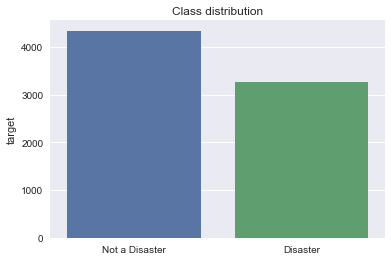

In [ ]:
plt.title('Class distribution')
sns.barplot(x=['Not a Disaster','Disaster'], y=train.target.value_counts())

In [ ]:
train = train.drop(columns=['keyword', 'location'])
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


## Text cleaning

In [ ]:
# cont = Contractions('./models/GoogleNews-vectors-negative300.bin')
# cont.load_models()

In [ ]:
def remove_htmltags(text):
    cleaned_text = re.sub(r'<.*?>', ' ', text)
    return cleaned_text

def remove_urls(text):
    cleaned_text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    return cleaned_text

def remove_emojis(text):
    pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642" 
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                         "]+", re.UNICODE)
    cleaned_text = re.sub(pattern, ' ', text)
    return cleaned_text

def replace_contractions(text):
    cleaned_text = list(cont.expand_texts([text]))[0]
    return cleaned_text

def remove_punctuations(text):    
    puncts = string.punctuation
    cleaned_text = "".join([ch if ch not in puncts else ' ' for ch in text])
    return cleaned_text

In [ ]:
stop_list = stopwords.words('english')

def remove_stopwords(text):    
    cleaned_text = [word.lower() for word in text.split() if word.lower() not in stop_list]
    return ' '.join(cleaned_text)

In [ ]:
train['clean'] = train['text'].apply(lambda x: remove_htmltags(x))
train['clean'] = train['clean'].apply(lambda x: remove_urls(x))
train['clean'] = train['clean'].apply(lambda x: remove_emojis(x))
# train['clean'] = train['clean'].apply(lambda x: replace_contractions(x))
train['clean'] = train['clean'].apply(lambda x: remove_punctuations(x))

In [ ]:
# train['final'] = train['clean'].apply(lambda x: remove_stopwords(x))

In [ ]:
def lowercase(text):
    return ' '.join([word.lower() for word in text.split()])

In [ ]:
train['final'] = train['clean'].apply(lambda x: lowercase(x))

In [ ]:
train.head()

,id,text,target,clean,final
0,1,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake M...,our deeds are the reason of this earthquake ma...
1,4,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are ...,all residents asked to shelter in place are be...
3,6,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation or...,13 000 people receive wildfires evacuation ord...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as ...,just got sent this photo from ruby alaska as s...


## Tokenizing the cleaned text

In [ ]:
def create_corpus_tokens(text_list):
    corpus = []
    for text in text_list:
        words = [word.lower() for word in word_tokenize(text)]
        corpus.append(words)
    return corpus

In [ ]:
corpus = create_corpus_tokens(train['final'])

In [ ]:
train_sample_count = len(corpus)
train_sample_count

7613

In [ ]:
corpus[0]

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all']

`corpus` is just a list of the tokenized text from the training dataset.

## Splitting train data for cross validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.final, train.target, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

4996    courageous and honest analysis of need to use ...
3263    zachzaidman 670thescore wld b a shame if that ...
4907    tell barackobama to rescind medals of honor gi...
2855    worried about how the ca drought might affect ...
4716    youngheroesid lava blast amp power red panther...
Name: final, dtype: object

In [ ]:
y_train.head()

4996    1
3263    0
4907    1
2855    1
4716    0
Name: target, dtype: int8

## Creating a Bag of Words using the `keras Tokenizer`

In [ ]:
max_len = 50

In [ ]:
tokenizer = Tokenizer(num_words=train_sample_count)
tokenizer.fit_on_texts(X_train)

In [ ]:
train_seqs = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seqs, maxlen=max_len, truncating='post', padding='post')
train_padded

array([[5824,    7, 3902, ...,    0,    0,    0],
       [5825, 5826, 5827, ...,    0,    0,    0],
       [ 615, 3019,    4, ...,    0,    0,    0],
       ...,
       [1763,  332, 1605, ...,    0,    0,    0],
       [ 591,  142,    2, ...,    0,    0,    0],
       [   6, 2072,    4, ...,    0,    0,    0]])

In [ ]:
test_seqs = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seqs, maxlen=max_len, padding='post', truncating='post')
test_padded

array([[  32,   11,   24, ...,    0,    0,    0],
       [   1, 1071,   27, ...,    0,    0,    0],
       [ 108, 5350, 3982, ...,    0,    0,    0],
       ...,
       [  98,  416,   62, ...,    0,    0,    0],
       [ 336,  268, 5034, ...,    0,    0,    0],
       [ 204, 1039,  627, ...,    0,    0,    0]])

In [ ]:
word_index = tokenizer.word_index
vocab_count = len(word_index)
print('Number of unique words:', vocab_count)

Number of unique words: 15133


## Creating the Embedding dictionary

In [ ]:
glove_vecs = {}
with open('glove.twitter.27B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], "float32")
        glove_vecs[word] = vectors
f.close()

In [ ]:
embedding_matrix = np.zeros((vocab_count + 1, 100))
for word, idx in word_index.items():
    if idx < vocab_count:
        embed_vec = glove_vecs.get(word)
        if embed_vec is not None:
            embedding_matrix[idx] = embed_vec

In [ ]:
embedding_matrix.shape

(15134, 100)

## Baseline model with GloVe

In [ ]:
model = Sequential()
model.add(Embedding(
    vocab_count+1, 100,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_len,
    trainable=False
))
model.add(LSTM(100, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=3e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           1513400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 1,593,901
Trainable params: 80,501
Non-trainable params: 1,513,400
_________________________________________________________________


In [ ]:
print(train_padded.shape)
print(y_train.shape)

(6090, 50)
(6090,)


In [ ]:
print(test_padded.shape)
print(y_test.shape)

(1523, 50)
(1523,)


In [ ]:
model.fit(
    train_padded,
    y_train,
    epochs=20,
    validation_data=(test_padded, y_test),
    verbose=1,
)

Epoch 1/20
191/191 [==============================] - 6s 29ms/step - loss: 0.5522 - accuracy: 0.7205 - val_loss: 0.4867 - val_accuracy: 0.8011
Epoch 2/20
191/191 [==============================] - 5s 27ms/step - loss: 0.4567 - accuracy: 0.7987 - val_loss: 0.4454 - val_accuracy: 0.8102
Epoch 3/20
191/191 [==============================] - 5s 26ms/step - loss: 0.4467 - accuracy: 0.7984 - val_loss: 0.4582 - val_accuracy: 0.7945
Epoch 4/20
191/191 [==============================] - 5s 27ms/step - loss: 0.4300 - accuracy: 0.8094 - val_loss: 0.4345 - val_accuracy: 0.8162
Epoch 5/20
191/191 [==============================] - 5s 28ms/step - loss: 0.4261 - accuracy: 0.8080 - val_loss: 0.4406 - val_accuracy: 0.8056
Epoch 6/20
191/191 [==============================] - 5s 27ms/step - loss: 0.4169 - accuracy: 0.8172 - val_loss: 0.4239 - val_accuracy: 0.8142
Epoch 7/20
191/191 [==============================] - 6s 29ms/step - loss: 0.4155 - accuracy: 0.8143 - val_loss: 0.4329 - val_accuracy: 0.8129

## Cross-validation

In [ ]:
pred_val = model.predict(test_padded)
pred_val_int = pred_val.round().astype('int')

Precision: 0.8221830985915493 | Recall: 0.7195685670261941 | F1-Score: 0.7674609695973706 | Accuracy: 0.814182534471438


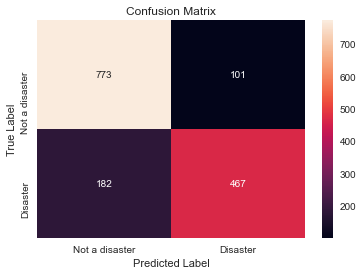

In [ ]:
precision, recall, fscore, train_support = score(y_test, pred_val_int, average='binary')
print('Precision: {} | Recall: {} | F1-Score: {} | Accuracy: {}'.format(
    precision, recall, fscore, accuracy_score(y_test, pred_val_int)))

cm = confusion_matrix(y_test, pred_val_int)
class_label = ["Not a disaster", "Disaster"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Making predictions on the test dataset

In [ ]:
test.drop(columns=['keyword','location'])

,id,text,clean,final
0,0,Just happened a terrible car crash,Just happened a terrible car crash,happened terrible car crash
1,2,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities s...,heard earthquake different cities stay safe ev...
2,3,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are...,forest fire spot pond geese fleeing across str...
3,9,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires,apocalypse lighting spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan
...,...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles ûò safety faste...
3259,10865,Storm in RI worse than last hurricane. My city...,Storm in RI worse than last hurricane My city...,storm ri worse last hurricane city amp 3others...
3260,10868,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago,green line derailment chicago
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,MEG issues Hazardous Weather Outlook HWO,meg issues hazardous weather outlook hwo


In [ ]:
test['clean'] = test['text'].apply(lambda x: remove_htmltags(x))
test['clean'] = test['clean'].apply(lambda x: remove_urls(x))
test['clean'] = test['clean'].apply(lambda x: remove_emojis(x))
# test['clean'] = test['clean'].apply(lambda x: replace_contractions(x))
test['clean'] = test['clean'].apply(lambda x: remove_punctuations(x))
# test['final'] = test['clean'].apply(lambda x: remove_stopwords(x))
test['final'] = test['clean'].apply(lambda x: lowercase(x))
test.head()

,id,keyword,location,text,clean,final
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities s...,heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are...,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


In [ ]:
seqs = tokenizer.texts_to_sequences(test.final)
padded = pad_sequences(seqs, maxlen=max_len, truncating='post', padding='post')

In [ ]:
pred = model.predict(padded)
pred_int = pred.round().astype('int')

## Evaluating model predictions against true labels

Precision: 0.846 | Recall: 0.69 | F1-Score: 0.76 | Accuracy: 0.813


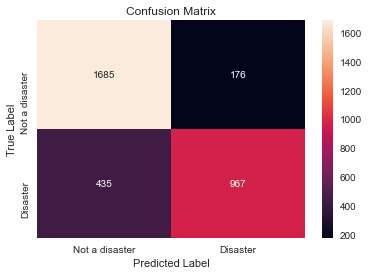

In [ ]:
test_leak = pd.read_csv("./output/submission.csv")

precision, recall, fscore, train_support = score(test_leak.target, pred_int, average='binary')
print('Precision: {} | Recall: {} | F1-Score: {} | Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore, 3), round(accuracy_score(test_leak.target, pred_int), 3)))

cm = confusion_matrix(test_leak.target, pred_int)
class_label = ["Not a disaster", "Disaster"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show() 